# 4 - Influential Classification Models (and Tools)

## Introduction

This Notebook (6) will continue on from the previous sections. This notebook will go through the process of using __Transfer Learning and Applying it__. Previously, the notebook focused on implementing the Inception model and MobieNet from TensorFlow Hub, here, the intention is to utilise transfer learning with Keras. Utilising models from Keras Applications that are pre-trained on richer datasets on new tasks. The focus here would be to fetch the parameters of pre-trained weights of the models that was trained on the ImageNet dataset, test different types of transfer learning such as freezing and fine-tuning of the feature_extractor layers.

## Supporting Utilities .py files:

In this Notebook, there will be a requirement to import the code/utilities from the following files (.py files):
- DataPrepCIFAR_utility.py
- customCallbacks_Keras.py
-

## Dataset:

For this part of the project, the CIFAR-100 dataset will be used, it is a collection of of 60,000 32x32 images that have 100 classes. CIFAR-100 was originally collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton. It iss also a subset of the 80 million tiny images dataset. There are 500 training images and 100 testing images per class. The 100 classes in the CIFAR-100 are grouped into 20 superclasses.

Source: https://www.cs.toronto.edu/~kriz/cifar.html

Further, the TensorFlow team offers a python package called "tensorflow_datasets" that provides the helper function to download tthis dataset as well as other more common ones. For the purposes of this project, the CIFAR-100 dataset will be download with this package.

Source: https://www.tensorflow.org/datasets/catalog/cifar100

## Requirements:
- Tensorflow 2.0 (GPU is better)
- Tensorflow-Hub
- Keras (GPU is better)

### Import the required libraries:

In [1]:
%matplotlib inline

import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import math
import timeit

In [2]:
import os
# from IPython.display import display, Image
# import matplotlib.pyplot as plt

# %matplotlib inline

# Set up the working directory for the images:
image_folderName = 'Description Images'
image_path = os.path.abspath(image_folderName) + '/'

In [3]:
tf.keras.backend.clear_session()

In [4]:
# Set the random set seed number: for reproducibility.
Seed_nb = 42

# Paramneter to run code block or not: 0 = to run code, 1 = ignore.
dont_run = 0

### GPU Information:

In [5]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
devices = sess.list_devices()
devices

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2070 SUPER, pci bus id: 0000:09:00.0, compute capability: 7.5



[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456, 17934848535087974416),
 _DeviceAttributes(/job:localhost/replica:0/task:0/device:GPU:0, GPU, 6586313605, 15118785098996826938)]

### Use RTX_GPU Tensor Cores for faster compute: FOR TENSORFLOW ONLY

Automatic Mixed Precision Training in TF. Requires NVIDIA DOCKER.

Sources:
- https://developer.nvidia.com/automatic-mixed-precision
- https://docs.nvidia.com/deeplearning/performance/mixed-precision-training/index.html#framework

When enabled, automatic mixed precision will do two things:

- Insert the appropriate cast operations into your TensorFlow graph to use float16 execution and storage where appropriate(this enables the use of Tensor Cores along with memory storage and bandwidth savings). 
- Turn on automatic loss scaling inside the training Optimizer object.

In [6]:
# os.environ['TF_ENABLE_AUTO_MIXED_PRECISION'] = '1'

EXAMPLE CODE: 

In [7]:
# # Graph-based example:
# opt = tf.train.AdamOptimizer()
# opt = tf.train.experimental.enable_mixed_precision_graph_rewrite(opt)
# train_op = opt.miminize(loss)

# # Keras-based example:
# opt = tf.keras.optimizers.Adam()
# opt = tf.train.experimental.enable_mixed_precision_graph_rewrite(opt)
# model.compile(loss=loss, optimizer=opt)
# model.fit(...)

### Use RTX_GPU Tensor Cores for faster compute: FOR KERAS API

Source:
- https://www.tensorflow.org/guide/keras/mixed_precision
- https://www.tensorflow.org/api_docs/python/tf/keras/mixed_precision/experimental/Policy

In [8]:
from tensorflow.keras.mixed_precision import experimental as mixed_precision

In [9]:
# Set for MIXED PRECISION:
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

Compute dtype: float16
Variable dtype: float32


## 1 - Transfer Learning:

Humans are able to learn things and apply it to new problems. For example, one part of our lifetime learning experiences are delivered in classrooms where there are teachers that explains the concepts of different topics. This guidance allows us to learn and develop without having to go through the early stages of trial and error until we find the correct path/answer. This behaviour is central to human intelligence. Essentially, this is what transfer learning is and it can be very powerful in the development of machine learning and deep learning. By applying guidance from pre-trained models and applying to new problems or a similar problem, is a way to develop a more proficient system(s) without having to relearn everything from scratch.

Typically, most machine learning systems are designed for a single task, where if these systems were to be applied on a different dataset, it would yield very poor results (like MNIST digits vs. ImageNet pictures and so on). As CNNs are trained to interpret some features of the dataset, it does make sense that the model should be able to partially be resued on a different but similar dataset like, classifying digits to classifying texts. The goal of transfer learning is to apply knowledge either from one task to another or to be adapted onto other domains.

## 2 - Transfering the Knowledge:

This section looks into how it is possible to transfer the knowledge gathered from one model to another? As with digital systems like Machine/Deep Learning, the data/weights can be easily stored and duplicated. 

Transfer learning for CNNs relies on conditioned instantiation, meaning it consists of reusing either the complete or partial architectures and weights of a past performant model and be instantiated as a new model for a new task. At this point, the model would be fine tuned for the new task/domain.

The 1st convolutional layer - extract low level features such as lines, edges or colour gradients, whereas the final convolutional layer - extracts shapes and patterns. The Dense layers at the end of the model are used to process these high level feature maps to make predictions. 

#### Typical setup for Transfer Learning models:

There are various strategies for the usage of pretrained CNNs. One of them is where the final prediction layers are removed, it would be used as an efficient __feature extractor__. If the model would be used for a simlar task where these feature extractors have trained for, it can be used to output pertinent features and then be processed by one or two dense layers which are trained to output predictions. 

The layers are often __FROZEN__ during the training phase to preserve the quality of the extracted feautres, meaning that the parameters will not be updated during the gradient descent phase. However, in other cases wher the tasks/domain differs, these layers will require __FINE TUNING__. This means that the feature extracting layers would be trained with the new prediction dense layers on the task. The next section will detail other use cases.

## 3 - Use Cases of Transfer learning:

Aside from the feature extractor case above, the following also details other use cases. Here, the questions asked are which pretrained model requires reusing or to be fine tuned or frozen?

List of cases:  
1) Limited training data for similar tasks. \
2) Abundant training data for similar tasks. \
3) Limited training data for dissimilar tasks. \
4) Abundant training data for dissimilar tasks.

### 3.1 - Limited training data for similar task:

When encountering a particular task that do not have enough training samples for the model to learn from, transfer learning is a solution where the model was previously trained on a larger but similar dataset. The pre-trained model can be used here by firstly removing the final layers and be replaced with new final layers. These layers can be trained on the new targeted task. 

For example, for the purpose of distinguishing bess and wasps, the ImageNet dataset has these two classes but does not contain enough data samples to produce an efficient CNN without overfitting. Therefore, the model can firstly be trained on the entire ImageNet dataset for the 1,000 classes, then its final dense layers are removed and replace with the output prediction layers specifically for 2 classes that are the bees and wasps. 

By fixing these parameters of the feature extractor layers (trained on the larger dataset), the network is able to retain its expressiveness that was previously developed on the richer dataset. 

### 3.2 - Abundant training data for similar tasks.:

One of reasons why networks tend to overfitting on the dataset is because it has less data samples. The bigger the dataset, the less chance the network has to overfitting it. In the case of larger training data, it is more common to unfreeze the latest layers of feature extractor for the purpose of fine tuning. This allows the network to extract the relevant features for the new task, this essentially translate to better learning during training and better prediction performance. Further, as the model is already close to convergence, it is common practice to use smaller learning rate in the fine tuning phase.

### 3.3 - Limited training data for dissimilar tasks:

Typically, the use of transfer learning is more advantageous if the task at hand are similar, but does not benefit a model that is used for visual recognition but was trained for audio tasks. For tasks that differs but however presents with a large enough dataset, it may not make sense to use an existing pretrained model. However, it has been demonstrated through experiments that the use of pretrained models performs much better with its pretrained weights than with random initialisation. 

### 3.4 - Abundant training data for dissimilar tasks:

This scenario would be the least ideal for a model to train on and can happen from time to time. In this case, careful considerations are required. For example, it would be crucial to reconsider the usage of deep models as training such a model can lead to overfitting, and that a deep pretrained model would consist of irrelevant features for the task. Interestingly, the solution here would be to utilise the first layers of the CNNs, as it tends to extract the low-level features from the data. This means that more layers other than the final dense layers would require removal, resulting in a shallow classifier. A shallow classifier can be adopted as the top half of the new dense layer for prediction, where this new model can be fine tuned for the specific task.

## 4 - Transfer Learning with TensorFlwo and Keras Examples: Model Surgery.

It is also common to utilise non-standard models/networks such as state-of-the-art CNNs or custom models by experts in their field/domain. This section will briefly go through the code implementations for the examples above, before a followed up section that applies transfer learning to an actual dataset. This section will also cover model surgery and selective training. 

Types of Model Surgery:
1) Removing Layers. \
2) Grafting Layers.

Types of Selective Training:
1) Restoring pretrained parameters. \
2) Freezing layers.

## Model Surgergy:

### 4.1 - Removing Layers:

Typically, when using pretrained models, one of the first tasks would be to remove the final prediction layers from the model and transforming it to feature extractors. 

In Keras, this can be done with the Sequential API where for "Sequential" models, the list of layers can be accessed with "model.layers" attribute. There is a "pop()" method that removes the last layer of the model. This can be done by knowing the number of layers to remove and specifying it in the parameter of the method.

For example in Keras:

In [10]:
# If statement to check if this code block should be executed.
if dont_run == 1:
    
    # Code example below:
    for i in range(nb_layers_to_remove):
        model.layers.pop()

The removal of layers in TenserFlow is not recommended as it can be highly complex to edit operational graph that supports the model. Note that unused graph operations are not executed during runtime, this means that having old layers incorporated in the compiled graph does not effect the pcompute performance of the new model. Therefore in TensorFlow, the layers are "removed" by pinpointing the last layer/operation of the pretrained model that is to be kept rather than outright removing them. 

If the corresponding Python object was lost as there are a lot of things to keep track, and that the name of the object is known, it can be found with TensorBoard. The represenative tensor can be recovered through a for-loop over the model layers and checking its name.

For example in Tensorflow:

In [11]:
# If statement to check if this code block should be executed.
if dont_run == 1:
    
    # Code example below:
    for layer in model.layers:
        if layer.name == name_of_lastLayer_to_keep:
            bottleneck_feaatures = layer.output
            break

As with all things Keras, it proveds the convience of simplicity to code design and thus this process, as compared to the one example above. Knowing the name of the last layer to be kept, after checking "model.summary()" for the layer name, a feature extractor can be instantiated in a couple of lines ans would be ready for use.

For example in Keras:

In [12]:
# If statement to check if this code block should be executed.
if dont_run == 1:
    
    # Code example below:
    bottleneck_features = model.get_layer(last_layer_name).output
    feature_extractor = Model(inputs = model.input,
                              outputs = bottleneck_features)

### 4.2 - Grafting Layers:

Grafting is where new prediction layers are added to the pretrained model (on top of the feature extractor). This process is straightforward and can be done easily.

For example with Keras:

In [13]:
# If statement to check if this code block should be executed.
if dont_run == 1:
    
    # Code example below:
    dense1 = Dense(...)(feature_extractor.ouput)
    new_model = Model(model.input, dense1)

## Selective Training:

The training phase with transfer learning can present to be complex, as the pretrained layers must be restored firstly and to define which of these layers are to be frozen.

### 4.3 - Restoring Pretrained Parameters:

For example with TensorFlow, there are utility functions to initialise ssome of the layers with pretrained weights. The following will show the saved parameters of a pretrained estimator to be used with a new model with layers of the same name.

The "warmStartSettings" is an initialiser that takes an optional argument "vars_to_warm_start" to provide the names of the specific variables (as a list or regex form) to be restored from the checkpoint files (ckpt).

In [14]:
# If statement to check if this code block should be executed.
if dont_run == 1:
    
    # Code example below:
    def model_func():
        # Define the new model, where it resuses pretrained weights/parameters as a feature extractor.
        
        # Remove "None" below when using this code.
        return None
    
    ckpt_path = '/path/to/pretrained/estimator/model.ckpt'
    ws = tf.estimator.WarmStartSettings(skpt_path)
    
    estimator = tf.estimator.Estimator(model_func, warm_start_from=ws)

For example with Keras, the restoration of the pretrained mdoel is done before its transformation for the new task. Note that although this is not the most optimal way to restore the complete model prior to removing some of the unwanted layers, the code is however, concise.

In [15]:
# If statement to check if this code block should be executed.
if dont_run == 1:
    
    # Code example below:
    # Assumes pretrained model was saved with the method "model.save()":
    model.tf.keras.models.load_model('path/to/pretrained/model.h5')
    
    # Next, is to "pop" or "add" layers for the creation of the new model.

### 4.4 - Freezing Layers:

For the Tensorflow example, it presents with the most versatile way of freezing layers. This is done by removing the "tf.Variable" attributes from the list of variables to be passed into the optimiser.

In [16]:
# If statement to check if this code block should be executed.
if dont_run == 1:
    
    # Code example below:
    # For this case, there is a need to freeze the model's layers with "conv" in the name:
    vars_to_train = model.trainable_varaibles
    vars_to_train = [ v for v in vars_to_train if "conv" in v.name]
    
    # Apply the optimiser to the remaining model's variables:
    optimizer.apply_gradietns( zip(gradient, vars_to_train) )

For the Keras example, the layers have a " .trainable " attribute that allows to be set as "False" to freeze the layers.

In [17]:
# If statement to check if this code block should be executed.
if dont_run == 1:
    
    # Code example below:
    for layer in feature_extractor.layers:
        layer.trainable = False # this freezes the complete extractor.

## 5 - Applying Transfer Learning on the CIFAR-100 Dataset:

Like previous noteboooks, the results gathered here are used to compare with the previously implemented models. This section will then apply transfer learning discussed above, utilising the ResNet model on the CIFAR-100 dataset.

## 5.1 - Hyperparamters:

In [18]:
# Define the Expected input and output shape for the model:
input_shape = [224, 224, 3]

batch_size = 64
nb_epochs = 300

## 5.2 - Data Preparation and Defining the Input Pipeline:

To use the TensorFlow package, please ensure to install it: "pip install tensorflow-datasets" or use the Anaconda Navigator.

### 5.2.1 - Download the Dataset:

In [19]:
import tensorflow_datasets as tfds
import DataPrepCIFAR_utility

In [20]:
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

In [21]:
# Get the Dataset Information:
cifarData_info = DataPrepCIFAR_utility.get_info()
print(cifarData_info)

tfds.core.DatasetInfo(
    name='cifar100',
    version=1.3.1,
    description='This dataset is just like the CIFAR-10, except it has 100 classes containing 600 images each. There are 500 training images and 100 testing images per class. The 100 classes in the CIFAR-100 are grouped into 20 superclasses. Each image comes with a "fine" label (the class to which it belongs) and a "coarse" label (the superclass to which it belongs).',
    urls=['https://www.cs.toronto.edu/~kriz/cifar.html'],
    features=FeaturesDict({
        'coarse_label': ClassLabel(shape=(), dtype=tf.int64, num_classes=20),
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=100),
    }),
    total_num_examples=60000,
    splits={
        'test': 10000,
        'train': 50000,
    },
    supervised_keys=('image', 'label'),
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {Learning multi

### 5.2.2 - Set up the dataset:

In [22]:
# Set the number of classes:
nb_classes = cifarData_info.features['label'].num_classes

# Define the number of images for training and validation:
nb_train_imgs = cifarData_info.splits['train'].num_examples
nb_valid_imgs = cifarData_info.splits['test'].num_examples

### 5.2.3 - Set the "steps_per_epoch" for Training and Validation Set:

From the previous code block, the dataset is compatible with Keras methods liike "model.fit()", but will also require the "steps_per_epoch" to be specified. This is the number of batches per epoch of the Dataset objects that has to be specified for the Keras method so that it can work properly together. This is done for the training batches ("steps_per_epoch") and validation batches ("validation_steps").

In [23]:
train_steps_per_epoch = math.ceil(nb_train_imgs / batch_size)

valid_steps_per_epoch = math.ceil(nb_valid_imgs / batch_size)

### 5.2.4 - Load in the Dataset:

In [24]:
# Training Dataset:
train_set_cifar = DataPrepCIFAR_utility.get_dataset(phase='train',
                                                    batch_size= batch_size,
                                                    nb_epochs= nb_epochs,
                                                    shuffle=True,
                                                    input_shape= input_shape,
                                                    seed= Seed_nb)

# Validation Dataset:
val_set_cifar = DataPrepCIFAR_utility.get_dataset(phase='test',
                                                  batch_size= batch_size,
                                                  nb_epochs= 1,
                                                  shuffle= False,
                                                  input_shape= input_shape,
                                                  seed= Seed_nb)

Now that the CIFAR-100 dataset has been prepared. The next stage is to call the ResNet model.

## 5.3 - Freeze the ResNet Feature Extractor:

This section will venture into instantiating a ResNet model from Keras Applications, where the model would have weights that were pretrained on the ImageNet dataset. The final layers of the model would be removed and therefore be a feature extractor. The new final dense layers will be incorporated as part of the model for the purpose of predictitons output for the CIFAR-100 dataset. 

Here in this section, the pretrained weights/parameters of the feature extraction layers of the ResNet will be frozen, thereby the only training will take place is the in the final dense layers for the CIFAR-100. The following will demonstrate how the pretrained weights are frozen.

### 5.3.1 - Building the ResNet model:

The ResNet-50 will be chosen here for the CIFAR-100 dataset. First, the model will be instantiated directly from Keras Applications with its pretrained weights without its final dense layers. This can be done by setting "include_top" parameter to be "False".

In [25]:
# Import the required Libraries:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

In [26]:
# Instantiate the ResNet-50 model:
resnet50_featureExtractor = tf.keras.applications.resnet50.ResNet50(include_top=False, 
                                                                    weights='imagenet',  
                                                                    input_shape=input_shape)

# Model Summary:
resnet50_featureExtractor.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

### 5.3.2 - Freeze the Feature Extractor Layers:

To do this, means that the layers of the network will be "non-trainable" where it will maintain the learnt weights derived from the training process over the ImageNet dataset. Note that the feature extractor layers here also means the convolutional layers. 

It is wise to consider that not all the layers should be frozen, as the only layers that require freezing are just the convolutional ones. Noting the architecture of the model from previous notebooks, and to simplify which layers are to be frozen or not:
- Convolutional layers = YES. (It is non-trainable).
- Regularisation layers = NO. (It is trainable).
- Batch-Normalisation layers = NO. (It is trainable).
 
As these trainable layers are added after the convolutional layers, it does consist of some trainable parameters, in this case, these parameters have become too specific on the ImageNet dataset, therefore it is better to re-train them for the purpose of the CIFAR-100 dataset, so that they are able to adapt to the new task at hand.

In [27]:
# Check for Layers that require freezing or not:
frozen_layers, trainable_layers = [], []

# Loop over the layers of the model to update the list of layers above:
for layer in resnet50_featureExtractor.layers:
    if isinstance(layer, tf.keras.layers.Conv2D):
        layer.trainable = False
        frozen_layers.append(layer.name)
        
    else:
        if len(layer.trainable_weights) > 0:
            trainable_layers.append(layer.name)

In [28]:
# Logging formats:
log_begin_red, log_begin_blue, log_begin_green = '\033[91m', '\n\033[94m', '\033[92m'
log_begin_bold, log_begin_underline = '\033[1m', '\033[4m'
log_end_format = '\033[0m'

In [29]:
# Log the lists of both frozen and trainable alyers:

# For FROZEN layers:
print("{2}Layers that are Frozen:{4} {0} ({3}total = {1}{4}).".format(
    frozen_layers, len(frozen_layers), log_begin_red, log_begin_bold, log_end_format))

# For TRAINABLE layers:
print("{2}Layers that will be Fine-tuned:{4} {0} ({3}total = {1}{4}).".format(
    trainable_layers, len(trainable_layers), log_begin_blue, log_begin_bold, log_end_format))


Layers that are Frozen: ['conv1_conv', 'conv2_block1_1_conv', 'conv2_block1_2_conv', 'conv2_block1_0_conv', 'conv2_block1_3_conv', 'conv2_block2_1_conv', 'conv2_block2_2_conv', 'conv2_block2_3_conv', 'conv2_block3_1_conv', 'conv2_block3_2_conv', 'conv2_block3_3_conv', 'conv3_block1_1_conv', 'conv3_block1_2_conv', 'conv3_block1_0_conv', 'conv3_block1_3_conv', 'conv3_block2_1_conv', 'conv3_block2_2_conv', 'conv3_block2_3_conv', 'conv3_block3_1_conv', 'conv3_block3_2_conv', 'conv3_block3_3_conv', 'conv3_block4_1_conv', 'conv3_block4_2_conv', 'conv3_block4_3_conv', 'conv4_block1_1_conv', 'conv4_block1_2_conv', 'conv4_block1_0_conv', 'conv4_block1_3_conv', 'conv4_block2_1_conv', 'conv4_block2_2_conv', 'conv4_block2_3_conv', 'conv4_block3_1_conv', 'conv4_block3_2_conv', 'conv4_block3_3_conv', 'conv4_block4_1_conv', 'conv4_block4_2_conv', 'conv4_block4_3_conv', 'conv4_block5_1_conv', 'conv4_block5_2_conv', 'conv4_block5_3_conv', 'conv4_block6_1_conv', 'conv4_block6_2_conv', 'conv4_block6_3_co

As it can be seen, the above concludes that there are 53 layers in total for both trainable and frozen layers.

#### Continue Building the model: 

Add the __"trainable" final dense layers__ to the ResNet model so that the model is able to output the predictions.

In [30]:
# Get the Output section of the ResNet model above:
features = resnet50_featureExtractor.output

# Apply the global average pooling:
avg_pool = GlobalAveragePooling2D(data_format = 'channels_last')(features)

# Add in the Final Dense Layers:
predictions = Dense(nb_classes, 
                    activation='softmax',
                   )(avg_pool)

# Instantiate the COMPLETE MODEL:
resnet50_freeze = Model(resnet50_featureExtractor.input, predictions)

### 5.3.3 - Training the ResNet-50 Model:

To do this, it is similar to previous notebooks.

In [31]:
# Import the required Libaries:
import collections
import functools
from customCallbacks_Keras import Simplified_LogCallback

#### Preparation for Training:

In [32]:
# Define the model optimiser:
optimiser = tf.keras.optimizers.SGD(momentum=0.9,
                                    nesterov=True)

# Add in for GPU Tensor Core Usage: USED WITH TensorFlow only.
# optimiser = tf.train.experimental.enable_mixed_precision_graph_rewrite(optimiser)

# Define the accuracy metric:
accuracy_metric = tf.metrics.SparseCategoricalAccuracy(name = 'acc')

# Define the top-5 accuracy metric: a.k.a Top-K
top5_acc_metric = tf.metrics.SparseTopKCategoricalAccuracy(k = 5,
                                                           name = 'top5_acc')

In [33]:
# Callback to log metrics at the end of each epoch: this saves space compared to Verbose = 1.
metrics_to_print = collections.OrderedDict( [("loss", "loss"), 
                                            ("v-loss", "val_loss"),
                                            ("acc", "acc"), 
                                            ("v-acc", "val_acc"),
                                            ("top5-acc", "top5_acc"), 
                                            ("v-top5-acc", "val_top5_acc")] 
                                          )

In [34]:
# Define the model directtory:
model_dir = '.\models\ResNet50_freezeAll_run1'

# Define the Callbacks:
callbacks = [
    
    # Callback to interrupt the training if the validation loss/metric stops imrpoving for some amount of epochs:
    tf.keras.callbacks.EarlyStopping(monitor ='val_acc',
                                    patience = 8,
                                    restore_best_weights = True
                                    ),
    
    # Callback to log the graph, Losses and Metrics into TensorBoard:
    tf.keras.callbacks.TensorBoard(log_dir = model_dir,
                                    histogram_freq = 0,
                                    write_graph = True
                                  ),
    
    # Callback to save the model: at every 5 epochs and specifies the poch and val-loss in the filename.
    tf.keras.callbacks.ModelCheckpoint(
        os.path.join(model_dir, 'weights-epoch{epoch:02}-loss{val_loss:.2f}.h5'), 
                     period = 5
                    ), 
    
    # Log the Callbacks:
    Simplified_LogCallback(metrics_dict = metrics_to_print,
                           nb_epochs = nb_epochs,
                           log_frequency= 5
                          )  
]



#### Load in Saved Weights:

In [35]:
# Load Previous Model Weights (when kernel crashes):
found_folder = None
for weight_folder in os.listdir('.\\models\\'):
    if(model_dir.split('.\\models\\')[1] == weight_folder):
        found_folder = str(weight_folder)

if(model_dir.split('.\\models\\')[1] == found_folder):
    All_saved_weightFiles = []
    for idx, filename in enumerate(os.listdir(model_dir)):
        if 'weights-epoch' in filename:
            All_saved_weightFiles.append(filename)
            weights_file_name = All_saved_weightFiles[-1]
            resnet50_freeze.load_weights(model_dir + '/' + weights_file_name)

    print("Model's weigth folder was found, proceeding to using previous Saved Weights.")
    print("Saved Weights Filename -> {}".format(weights_file_name))
        
else:
    print("Model's weight folder was not found inside '.\models\' folder. Proceeding to creating a new one.'")
    pass    


Model's weigth folder was found, proceeding to using previous Saved Weights.
Saved Weights Filename -> weights-epoch35-loss0.08.h5


#### Compile the model:

In [36]:
# Compile the Model:
resnet50_freeze.compile(optimizer = optimiser,
                 loss = 'sparse_categorical_crossentropy',
                 metrics = [accuracy_metric, top5_acc_metric]
                )

#### Run the training process for the model:

In [37]:
# running time calculation
start = timeit.default_timer()

In [38]:
history_resnet50_freeze = resnet50_freeze.fit(train_set_cifar,
                                              epochs = nb_epochs,
                                              steps_per_epoch= train_steps_per_epoch,
                                              validation_data= (val_set_cifar),
                                              validation_steps= valid_steps_per_epoch,
                                              verbose=0,
                                              callbacks= callbacks)

Training: start
Epoch  1/300: loss = 0.120; v-loss = 0.072; acc = 0.964; v-acc = 0.980; top5-acc = 0.999; v-top5-acc = 1.000
Epoch  6/300: loss = 0.121; v-loss = 0.076; acc = 0.962; v-acc = 0.979; top5-acc = 0.999; v-top5-acc = 1.000
Training: end


In [39]:
# Stop the timer:
stop = timeit.default_timer()
print('Time: {} Minutes'.format(round((stop - start)/60, 2)))
print('Time: {} hours'.format(round((stop - start)/3600, 2)))

Time: 23.79 Minutes
Time: 0.4 hours


## 6 - Model Performance:

## 6.1 - Inspect TensorBoard:

These can also be found in TensorBoard with the input in terminal: "tensorboard --logdir ./models" or in this case, "tensorboard --logdir .\models\ResNet50_freezeAll_run1"

![Tensorboard screenshot 1](./Description Images/ResNet50_freezeAll_run1.png)

## 6.2 - Plot of the Model's Performance:

NOTE: the "history" object returned from the "model.fit()" method also provides data for plotting the training metrics. The following till plot these metrics.

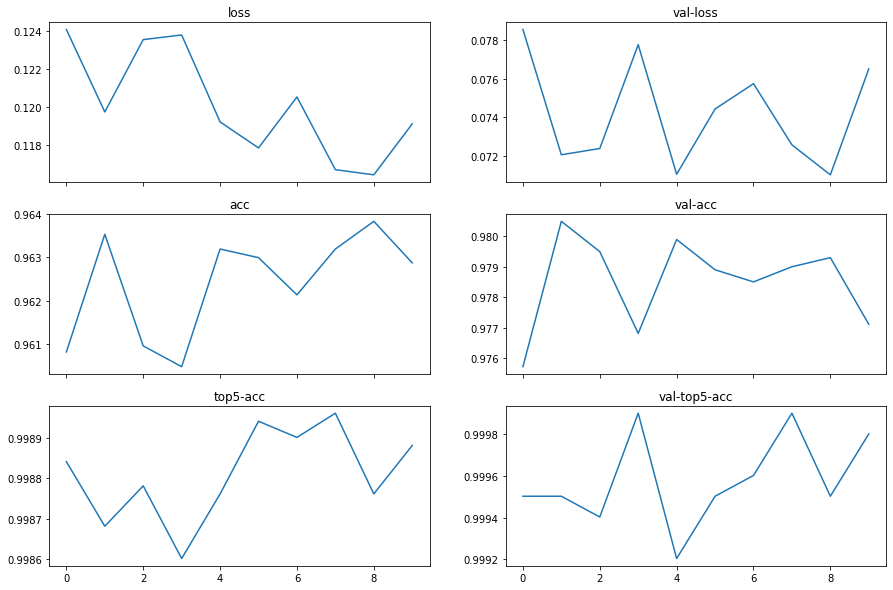

In [40]:
fig, ax = plt.subplots(3, 2, figsize=(15, 10), sharex='col') # add parameter `sharey='row'` for a more direct comparison
ax[0, 0].set_title("loss")
ax[0, 1].set_title("val-loss")
ax[1, 0].set_title("acc")
ax[1, 1].set_title("val-acc")
ax[2, 0].set_title("top5-acc")
ax[2, 1].set_title("val-top5-acc")

ax[0, 0].plot(history_resnet50_freeze.history['loss'])
ax[0, 1].plot(history_resnet50_freeze.history['val_loss'])
ax[1, 0].plot(history_resnet50_freeze.history['acc'])
ax[1, 1].plot(history_resnet50_freeze.history['val_acc'])
ax[2, 0].plot(history_resnet50_freeze.history['top5_acc'])
ax[2, 1].plot(history_resnet50_freeze.history['val_top5_acc'])


In [41]:
# Get the best performing scores:
best_val_accuracy = max(history_resnet50_freeze.history['val_acc']) * 100
best_val_top5accuracy = max(history_resnet50_freeze.history['val_top5_acc']) * 100

# Print out the results:
print("Best Validation Accuracy: {:2.2f}%".format(best_val_accuracy))
print("Best Validation Top 5 Accuracy: {:2.2f}%".format(best_val_top5accuracy))

Best Validation Accuracy: 98.05%
Best Validation Top 5 Accuracy: 99.99%


### Observation:

It can be seen that by carefully freezing the weigths of feature extractor tthat was trained on the ImageNet dataset, the model was able to achieve a greater accuracy of ~96% with a validation accuracy of ~98%. It was also able to obtain a top-5 validation accuracy of ~99%. Comparing to the self-implemented ResNet-50 model (Best Validation Accuracy: 66.53%, Best Validation Top 5 Accuracy: 89.45%), the transfer learning ResNet model was definitely able to achieve much better results.

## 7 - Fine-Tuning the Resnet Feature Extractor:

As mentioned earlier in this notebook, fine-tuning is advantageous when the training dataset can be said to be big enough where the model won't overfit it. In this section, the ResNet-50 model and its pretrained weights/parameters (layers) will be instantiated again. However, a complete freezing of the feature extractor layers __will not__ be done for the purpose of fine tuning the deeper (latest) higher-level convolutional layers. 

## 7.1 - Selectively Freezing Layers of the model:

With what was previously mentioned, the higher-level convolutional layers are in the deeper layers of the model, this means that the weights of the first few layers will be fixed (frozen) while the remainding layers will undergo the training phase. 

The following is an example code to demonstrate the logic behind selective freezing. For example here, the weights of the 3 first macro-blocks (these macro blocks were mentioned in Notebook 2 Section 3.2.5) will be fixed, where the rest of the layers will be fine tuned during training.

In [42]:
for layer in resnet50_featureExtractor.layers:
    if 'res5' in layer.name:
        # The devs of Keras have explicitly named the layers in the ResNet model, 
        # to identify which macro-block (and blocks) in each layer belongs to.
        # Here, if the loop reaches the layer named 'res5' for 'resnet5', it would mean that
        # the fourth macro-block was reached, passing the 3 first macro-blocks. 
        break
    
    if isinstance(layer, tf.keras.layers.Conv2D):
        layer.trainable = False

## 7.2 - Meta-Iterating to discover the best Transfer Learning Solution:

It should be noted that in practice, __the decision in which layers will be fine-tuned or not, will require several iterations of training__. This is to compare the performance of each instantiaed model in each loop. 

This section will dive into the testing of different __Macro-Configurations__, where the freezing of a variable number of layers will be conducted, then the performance of the resulting network will be evaluated during the training phase. The exercise here will go through freezing macro-blocks from 0 to all 4 of them in the ResNet feeature extractor model.

__Warning:__ This part of will or may take up to days of training. It is recommended to run these in parallel. Also note that "ModelCheckpoint()" callback can be used to restore the models if the training process were to be interrupted. This can be implemented by the following: "reset50_finetine.load_weights(filename_latest_checkpoint)" before launching the training phase again. Further, the Keras logs will be switched off for this section as it can overload the print out and make the notebook unreadable.

#### Number of macro blocks to freeze:

In [49]:
# Selecting the number of macro blocks to freeze:
nb_macroblocks_to_freeze = [0, 1, 2, 3]

#### Meta-Iterating of the models:

In [50]:
histories = dict()
histories['freeze all'] = history_resnet50_freeze

runing_total_time = 0

# Loop over the training with different macro blocks:
for freeze_nb in nb_macroblocks_to_freeze:
    
    print('{1}{2} >> {3}ResNet-50 with {0} macro-blocks(s) frozen{4}:'.format(
        freeze_nb, log_begin_green, log_begin_bold, log_begin_underline, log_end_format))

    # STAGE 1 ---------------------------------------------------------------------------
    # Instantiate a new ResNet model (classifier) each time:
    resnet50_feature_extractor = tf.keras.applications.resnet50.ResNet50(include_top = False,
                                                                         weights = 'imagenet',
                                                                         input_shape = input_shape,
                                                                         classes = nb_classes)

    # Add the final prediction layers:
    features = resnet50_feature_extractor.output
    avg_pool = GlobalAveragePooling2D(data_format = 'channels_last')(features)
    predictions = Dense(nb_classes, 
                        activation='softmax',
                       )(avg_pool)

    # Complete the model instantiation:
    resnet50_finetune = Model(resnet50_feature_extractor.input, predictions)

    # STAGE 2 ---------------------------------------------------------------------------
    # Freeze the desired layers:
    break_layer_name = 'res{}'.format(freeze_nb + 2) if freeze_nb > 0 else 'conv1'

    frozen_layers = []

    # Loop over the layers to determine which is frozen or trainable:
    for layer in resnet50_finetune.layers:
        if break_layer_name in layer.name:
            break

        if isinstance(layer, tf.keras.layers.Conv2D):
            # Check if the layer is a Convolution, and that it isn't after the 1st layer, so that it is not trained.
            layer.trainable = False
            frozen_layers.append(layer.name)

    print('\t> {2}Layers frozen:{4} {0} ({3}total = {1}{4}).'.format(
        frozen_layers, len(frozen_layers), log_begin_red, log_begin_bold, log_end_format))

    # STAGE 3 ---------------------------------------------------------------------------
    # Reinstantiate the Input Pipelines: Begining with the data iteration.  
    # Training Dataset:
    train_set_cifar = DataPrepCIFAR_utility.get_dataset(phase='train',
                                                        batch_size= batch_size,
                                                        nb_epochs= nb_epochs,
                                                        shuffle=True,
                                                        input_shape= input_shape,
                                                        seed= Seed_nb)

    # Validation Dataset:
    val_set_cifar = DataPrepCIFAR_utility.get_dataset(phase='test',
                                                      batch_size= batch_size,
                                                      nb_epochs= 1,
                                                      shuffle= False,
                                                      input_shape= input_shape,
                                                      seed= Seed_nb)

    # STAGE 4 ---------------------------------------------------------------------------
    # Set up the training process:

    # Define the model optimiser:
    optimiser = tf.keras.optimizers.SGD(momentum=0.9,
                                        nesterov=True)

    # Define the accuracy metric:
    accuracy_metric = tf.metrics.SparseCategoricalAccuracy(name = 'acc')

    # Define the top-5 accuracy metric: a.k.a Top-K
    top5_acc_metric = tf.metrics.SparseTopKCategoricalAccuracy(k = 5,
                                                               name = 'top5_acc')


    # Define the model directtory:
    model_dir = '.\models\ResNet50_freeze_{}_macroblock'.format(freeze_nb)

    # Define the Callbacks:
    callbacks = [

        # Callback to interrupt the training if the validation loss/metric stops imrpoving for some amount of epochs:
        tf.keras.callbacks.EarlyStopping(monitor ='val_acc',
                                        patience =8,
                                        restore_best_weights = True
                                        ),

        # Callback to log the graph, Losses and Metrics into TensorBoard:
        tf.keras.callbacks.TensorBoard(log_dir = model_dir,
                                        histogram_freq = 0,
                                        write_graph = True
                                      ),

        # Callback to save the model: at every 5 epochs and specifies the poch and val-loss in the filename.
        tf.keras.callbacks.ModelCheckpoint(
            os.path.join(model_dir, 'weights-epoch{epoch:02}-loss{val_loss:.2f}.h5'), period = 5
                                        )

    ]

    # Load Previous Model Weights (when kernel crashes):
    found_folder = None
    for weight_folder in os.listdir('.\\models\\'):
        if(model_dir.split('.\\models\\')[1] == weight_folder):
            found_folder = str(weight_folder)

    if(model_dir.split('.\\models\\')[1] == found_folder):
        All_saved_weightFiles = []
        for idx, filename in enumerate(os.listdir(model_dir)):
            if 'weights-epoch' in filename:
                All_saved_weightFiles.append(filename)
                weights_file_name = All_saved_weightFiles[-1]
                resnet50_finetune.load_weights(model_dir + '/' + weights_file_name)

        print("Model's weigth folder was found, proceeding to using previous Saved Weights.")
        print("Saved Weights Filename -> {}".format(weights_file_name))

    else:
        print("Model's weight folder was not found inside '.\models\' folder. Proceeding to creating a new one.'")
    
    # Compile the Model:
    resnet50_finetune.compile(optimizer = optimiser,
                              loss = 'sparse_categorical_crossentropy',
                              metrics = [accuracy_metric, top5_acc_metric]
                             )

    # Train the model:
    print('\t> Training - {0}start{1} (logs = off)'.format(log_begin_red, log_end_format))

    # running time calculation
    start = timeit.default_timer()

    # Run the model through the training:
    history_resnet50_finetune = resnet50_finetune.fit(train_set_cifar,
                                                      epochs = nb_epochs,
                                                      steps_per_epoch= train_steps_per_epoch,
                                                      validation_data= (val_set_cifar),
                                                      validation_steps= valid_steps_per_epoch,
                                                      verbose=0,
                                                      callbacks= callbacks)

    print('\t> Training - {0}over{1}'.format(log_begin_green, log_end_format))

    # Stop the timer:
    stop = timeit.default_timer()
    print('Time: {} Minutes'.format(round((stop - start)/60, 2)))
    print('Time: {} hours'.format(round((stop - start)/3600, 2)))

    # Save to total time taken:
    runing_total_time += round((stop - start)/3600, 2)

    print('Current Running Time Taken: {} Hours'.format(runing_total_time))
    print('Current Running Time Taken: {} Days'.format(round((runing_total_time / 24), 2)))

    # STAGE 5 ---------------------------------------------------------------------------
    # Print the results/metrics of each of the Tested Models:

    acc = history_resnet50_finetune.history['acc'][-1] * 100
    top5 = history_resnet50_finetune.history['top5_acc'][-1] * 100
    val_acc = history_resnet50_finetune.history['val_acc'][-1] * 100
    val_top5 =history_resnet50_finetune.history['val_top5_acc'][-1] * 100
    epochs = len(history_resnet50_finetune.history['val_loss'])

    print("\t> Results after {5}{0}{6} epochs:\t{5}acc = {1:.2f}%; top5 = {2:.2f}%; val_acc = {3:.2f}%; val_top5 = {4:.2f}%{6}".format(
        epochs, acc, top5, val_acc, val_top5, log_begin_bold, log_end_format))

    # STAGE 6 ---------------------------------------------------------------------------
    # Update the Histories Dict:
    histories['freeze {}'.format(freeze_nb)] = history_resnet50_finetune


 >> ResNet-50 with 0 macro-blocks(s) frozen:


	> Layers frozen: [] (total = 0).


Model's weigth folder was found, proceeding to using previous Saved Weights.
Saved Weights Filename -> weights-epoch25-loss0.01.h5
	> Training - start (logs = off)
	> Training - over
Time: 46.22 Minutes
Time: 0.77 hours
Current Running Time Taken: 0.77 Hours
Current Running Time Taken: 0.03 Days
	> Results after 16 epochs:	acc = 99.73%; top5 = 100.00%; val_acc = 99.59%; val_top5 = 99.99%
 >> ResNet-50 with 1 macro-blocks(s) frozen:


	> Layers frozen: ['conv1_conv', 'conv2_block1_1_conv', 'conv2_block1_2_conv', 'conv2_block1_0_conv', 'conv2_block1_3_conv', 'conv2_block2_1_conv', 'conv2_block2_2_conv', 'conv2_block2_3_conv', 'conv2_block3_1_conv', 'conv2_block3_2_conv', 'conv2_block3_3_conv', 'conv3_block1_1_conv', 'conv3_block1_2_conv', 'conv3_block1_0_conv', 'conv3_block1_3_conv', 'conv3_block2_1_conv', 'conv3_block2_2_conv', 'conv3_block2_3_conv', 'conv3_block3_1_conv', 'conv3_block3_2_conv', 'conv3_block3_3_conv', 'conv3_block4_1_conv', 'conv3_block4_2_conv', 'conv3_block4_3_conv', 'conv4_block1_1_conv', 'conv4_block1_2_conv', 'conv4_block1_0_conv', 'conv4_block1_3_conv', 'conv4_block2_1_conv', 'conv4_block2_2_conv', 'conv4_block2_3_conv', 'conv4_block3_1_conv', 'conv4_block3_2_conv', 'conv4_block3_3_conv', 'conv4_block4_1_conv', 'conv4_block4_2_conv', 'conv4_block4_3_conv', 'conv4_block5_1_conv', 'conv4_block5_2_conv', 'conv4_block5_3_conv', 'conv4_block6_1_conv', 'conv4_block6_2_conv', 'conv4_block6_3_conv', '

Model's weight folder was not found inside '.\models' folder. Proceeding to creating a new one.'
	> Training - start (logs = off)
	> Training - over
Time: 166.63 Minutes
Time: 2.78 hours
Current Running Time Taken: 3.55 Hours
Current Running Time Taken: 0.15 Days
	> Results after 71 epochs:	acc = 94.04%; top5 = 99.79%; val_acc = 96.27%; val_top5 = 99.83%
 >> ResNet-50 with 2 macro-blocks(s) frozen:


	> Layers frozen: ['conv1_conv', 'conv2_block1_1_conv', 'conv2_block1_2_conv', 'conv2_block1_0_conv', 'conv2_block1_3_conv', 'conv2_block2_1_conv', 'conv2_block2_2_conv', 'conv2_block2_3_conv', 'conv2_block3_1_conv', 'conv2_block3_2_conv', 'conv2_block3_3_conv', 'conv3_block1_1_conv', 'conv3_block1_2_conv', 'conv3_block1_0_conv', 'conv3_block1_3_conv', 'conv3_block2_1_conv', 'conv3_block2_2_conv', 'conv3_block2_3_conv', 'conv3_block3_1_conv', 'conv3_block3_2_conv', 'conv3_block3_3_conv', 'conv3_block4_1_conv', 'conv3_block4_2_conv', 'conv3_block4_3_conv', 'conv4_block1_1_conv', 'conv4_block1_2_conv', 'conv4_block1_0_conv', 'conv4_block1_3_conv', 'conv4_block2_1_conv', 'conv4_block2_2_conv', 'conv4_block2_3_conv', 'conv4_block3_1_conv', 'conv4_block3_2_conv', 'conv4_block3_3_conv', 'conv4_block4_1_conv', 'conv4_block4_2_conv', 'conv4_block4_3_conv', 'conv4_block5_1_conv', 'conv4_block5_2_conv', 'conv4_block5_3_conv', 'conv4_block6_1_conv', 'conv4_block6_2_conv', 'conv4_block6_3_conv', '

Model's weight folder was not found inside '.\models' folder. Proceeding to creating a new one.'
	> Training - start (logs = off)
	> Training - over
Time: 299.41 Minutes
Time: 4.99 hours
Current Running Time Taken: 8.54 Hours
Current Running Time Taken: 0.36 Days
	> Results after 128 epochs:	acc = 96.24%; top5 = 99.88%; val_acc = 97.69%; val_top5 = 99.98%
 >> ResNet-50 with 3 macro-blocks(s) frozen:


	> Layers frozen: ['conv1_conv', 'conv2_block1_1_conv', 'conv2_block1_2_conv', 'conv2_block1_0_conv', 'conv2_block1_3_conv', 'conv2_block2_1_conv', 'conv2_block2_2_conv', 'conv2_block2_3_conv', 'conv2_block3_1_conv', 'conv2_block3_2_conv', 'conv2_block3_3_conv', 'conv3_block1_1_conv', 'conv3_block1_2_conv', 'conv3_block1_0_conv', 'conv3_block1_3_conv', 'conv3_block2_1_conv', 'conv3_block2_2_conv', 'conv3_block2_3_conv', 'conv3_block3_1_conv', 'conv3_block3_2_conv', 'conv3_block3_3_conv', 'conv3_block4_1_conv', 'conv3_block4_2_conv', 'conv3_block4_3_conv', 'conv4_block1_1_conv', 'conv4_block1_2_conv', 'conv4_block1_0_conv', 'conv4_block1_3_conv', 'conv4_block2_1_conv', 'conv4_block2_2_conv', 'conv4_block2_3_conv', 'conv4_block3_1_conv', 'conv4_block3_2_conv', 'conv4_block3_3_conv', 'conv4_block4_1_conv', 'conv4_block4_2_conv', 'conv4_block4_3_conv', 'conv4_block5_1_conv', 'conv4_block5_2_conv', 'conv4_block5_3_conv', 'conv4_block6_1_conv', 'conv4_block6_2_conv', 'conv4_block6_3_conv', '

Model's weight folder was not found inside '.\models' folder. Proceeding to creating a new one.'
	> Training - start (logs = off)
	> Training - over
Time: 285.69 Minutes
Time: 4.76 hours
Current Running Time Taken: 13.299999999999999 Hours
Current Running Time Taken: 0.55 Days
	> Results after 122 epochs:	acc = 95.88%; top5 = 99.87%; val_acc = 97.74%; val_top5 = 99.98%


## 8 - Inspect TensorBoard:

These can also be found in TensorBoard with the input in terminal: "tensorboard --logdir ./models" or in this case, "tensorboard --logdir .\models\ResNet50_freeze_/////////NUMBER//////_macroblock"


![Tensorboard screenshot - joint results](./Description\ Images/ResNet50_freezeAll_run1.png)

## 9 - Plot of the Model's Performance:

NOTE: the "history" object returned from the "model.fit()" method also provides data for plotting the training metrics. The following till plot these metrics.

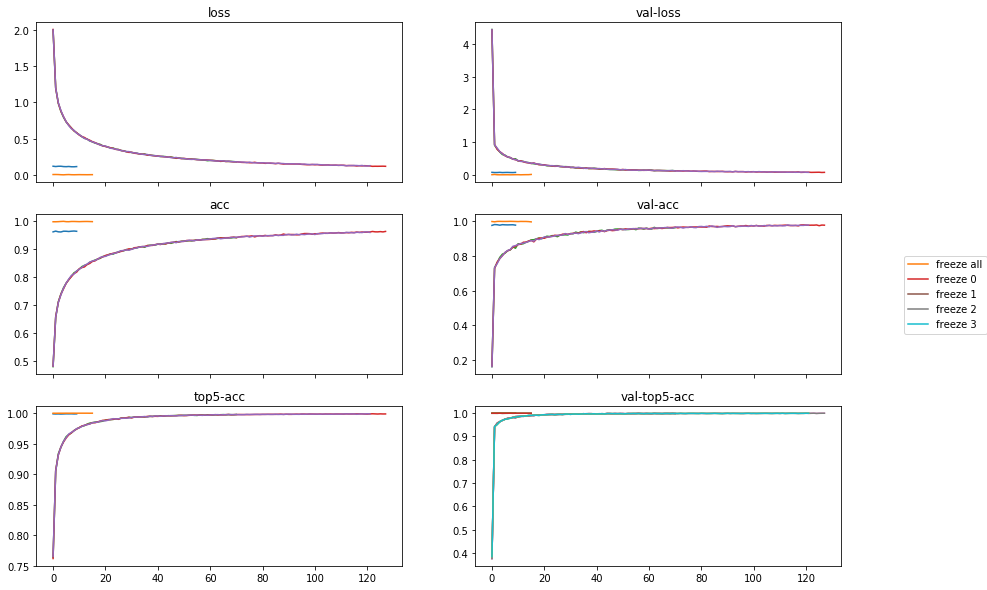

In [51]:
fig, ax = plt.subplots(3, 2, figsize=(15, 10), sharex='col') # add parameter `sharey='row'` for a more direct comparison
ax[0, 0].set_title("loss")
ax[0, 1].set_title("val-loss")
ax[1, 0].set_title("acc")
ax[1, 1].set_title("val-acc")
ax[2, 0].set_title("top5-acc")
ax[2, 1].set_title("val-top5-acc")

lines, labels = [], []

for config_name in histories:
    history = histories[config_name]

    ax[0, 0].plot(history.history['loss'])
    ax[0, 1].plot(history.history['val_loss'])
    ax[1, 0].plot(history.history['acc'])
    ax[1, 1].plot(history.history['val_acc'])
    ax[2, 0].plot(history.history['top5_acc'])
    ax[2, 1].plot(history.history['val_top5_acc'])
    
    line = ax[2, 1].plot(history.history['val_top5_acc'])
    lines.append(line[0])
    labels.append(config_name)
    
fig.legend(lines, labels, loc='center right', borderaxespad = 0.1)
plt.subplots_adjust(right=0.87)

In [53]:
# Get the best performing scores:
best_val_accuracy = max(history_resnet50_finetune.history['val_acc']) * 100
best_val_top5accuracy = max(history_resnet50_finetune.history['val_top5_acc']) * 100

# Print out the results:
print("Best Validation Accuracy: {:2.2f}%".format(best_val_accuracy))
print("Best Validation Top 5 Accuracy: {:2.2f}%".format(best_val_top5accuracy))

Best Validation Accuracy: 97.81%
Best Validation Top 5 Accuracy: 99.98%


### Observation:

Taking a look at the charts above, most the models can be seen to converge quickly in terms of training loss and acuracy metrics. Note that for the 'freeze all' and 'freeze 0' models where the lines are shorter, this is because the kernel crashed a few times, and I was able to load in the previous weights of the last training steps before crashing to continue the model training. 

For this experiment on the CIFAR-100 dataset, freezing the feture extractor layers of these models aat various layers also leads to an overall highestvalidation accuracy. Taking a further look in detail to the curves of the 'acc' and 'val-acc' charts, it can be seen that most of the models with the frozen blocks could be slightly overfitting the dataset, as seen with worst validation accuracy scores but having a better training accuracy score.

The CIFAR-100 dataset is relatively small as it is a small subset of the ImageNet dataset, but its images are in a lower quality format of 32 x 32 pixels, meaning that the frozen feature extractor layers could have trouble finding patterns or recognising the downscaled higher level features. 

Overall, this experiemtn proves that by instantiating a Transfer Learning ResNet model with pretrained weights (such as the ImageNet weights) rather than random ones, the performance of the model itsel was significantly better when compared to the self-implemented ResNet model.

Other considerations in the future would be finding the different configurations of hyperparameters to find the best configuration. This is of course a time taxing process but nonetheless will contribute to a high performing model.

## 10 - Plot the Predictions:

## Conclusions:



## Summary:

Although this is not the end of this project, it does conclude the 1st notebook relevant to the theory of these advanced deep learning models. Please go to check out __Notebook 7__ for the ____.